<a href="https://colab.research.google.com/github/AbdullahMakhdoom/Image-Search-Engine/blob/main/improve_search_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective** : Although the pre-trained models (trained on ImageNet dataset) provide a good starting point for similarity computation in most scenarios, yet if we tune the model to adapt to our specific problem's dataset, the model will perform even more accurately to find similar images.

  In this notebook, we will compare the search accuracy of pre-trained Caltech101 features (generated from ResNet-50 pre-trained on ImageNet) with the fine-tuned ResNet-50 features(fine-tuned on Caltech101).
The fine-tuning was performed in 'feature-extraction.ipynb' notebook and saved in Google Drive '.pickle' files.

We will also visualize how fine-tuning results in more cleaner seperation of clusters using t-SNE.

In [2]:
# import all required packages
import numpy as np
import pickle
from tqdm import tqdm, tqdm_notebook
import random
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from textwrap import wrap

import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Mount the Google drive before loading the pre-trained and fine-tuned '.pickle' files

In [28]:
feature_list = pickle.load(open('/content/drive/MyDrive/Caltech101-features/features-caltech101-resnet.pickle',
                                'rb'))
finetuned_feature_list = pickle.load(open('/content/drive/MyDrive/Caltech101-features/features-caltech101-resnet-finetuned.pickle',
                                          'rb'))

In [4]:
# Also load the filenames and class_ids
filenames = pickle.load(open('/content/drive/MyDrive/Caltech101-features/filenames-caltech101.pickle', 'rb'))
class_ids = pickle.load(open('/content/drive/MyDrive/Caltech101-features/class_ids-caltech101.pickle', 'rb'))

### Helper Functions

In [8]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]

# Helper function to calculate accuracy
def calculate_accuracy(feature_list):
    num_nearest_neighbors = 5
    correct_predictions = 0
    incorrect_predictions = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    for i in tqdm_notebook(range(len(feature_list))):
        distances, indices = neighbors.kneighbors([feature_list[i]])
        for j in range(1, num_nearest_neighbors):
            if (classname(filenames[i]) == classname(
                    filenames[indices[0][j]])):
                correct_predictions += 1
            else:
                incorrect_predictions += 1
    print(
        "Accuracy is ",
        round(
            100.0 * correct_predictions /
            (1.0 * correct_predictions + incorrect_predictions), 2))
    
# Helper function to dis

####1. Accuracy of Brute Force over Caltech101 features

In [9]:
calculate_accuracy(feature_list[:])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Accuracy is  88.36


####2. Accuracy of Brute Force over the PCA compressed Caltech101 features

In [11]:
num_feature_dimensions = 100
pca = PCA(n_components=num_feature_dimensions)
pca.fit(feature_list)
feature_list_compressed = pca.transform(feature_list[:])

In [12]:
calculate_accuracy(feature_list_compressed[:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Accuracy is  88.48


####3. Accuracy of Brute Force over finetuned Caltech101 features

In [19]:
calculate_accuracy(finetuned_feature_list[:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Accuracy is  95.52


####4. Accuracy over Brute Force over the PCA compressed finetuned Caltech101 features

In [20]:
# Perform PCA on Finetuned features
num_feature_dimensions = 100
pca = PCA(n_components=num_feature_dimensions)
pca.fit(finetuned_feature_list)
feature_list_compressed = pca.transform(finetuned_feature_list[:])

In [21]:
calculate_accuracy(feature_list_compressed[:])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Accuracy is  95.53


### Results

Accuracy on Caltech101

| Algorithm | Accuracy using Pretrained features| Accuracy using Finetuned features | 
|-------------|----------------------------|------------------------|
| Brute Force | 88.36 | 95.52 | 
| PCA + Brute Force | 88.48  |  95.53 |



---



---




### t-SNE Visualization of Features : Pre-trained vs Fine-tuned 

In the remaining portion of this notebook, we will find the least accuract performing categories, visualize them with t-SNE, fine-tune and see how their t-SNE plot changes.



Helper function to display accuracy stats and plot similar images

In [5]:
def display(dic, per_class, neighbors, message):
    for key in dic:
        print(key, "\tAccuracy: ", per_class[key])
    for each_class in dic:
        indices_of_class = [
            i for i, j in enumerate(filenames) if classname(j) == each_class
        ]
        random_image_index = random.choice(indices_of_class)
        distances, indices = neighbors.kneighbors(
            [feature_list[random_image_index]])
        similar_image_paths = [filenames[random_image_index]] + \
            [filenames[indices[0][i]] for i in range(1, 4)]
        plot_images(similar_image_paths, distances[0], message)

Helper function that calculates accuracy using Nearest Neighbours Brute Force algorithm and returns classes that the model performed least accurately.

In [6]:
def get_least_accurate_classes(feature_list):
    per_class_acc = {}
    num_nearest_neighbors = 5
    num_correct_predictions = 0
    num_incorrect_predictions = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    for i in tqdm_notebook(range(len(feature_list))):
        distances, indices = neighbors.kneighbors([feature_list[i]])
        for j in range(1, num_nearest_neighbors):
            predicted_class = classname(filenames[indices[0][j]])
            ground_truth = classname(filenames[i])
            if (predicted_class not in per_class_acc):
                per_class_acc[predicted_class] = [0, 0, 0]
            if ground_truth == predicted_class:
                num_correct_predictions += 1
                per_class_acc[predicted_class][0] += 1
                per_class_acc[predicted_class][2] += 1
            else:
                num_incorrect_predictions += 1
                per_class_acc[predicted_class][1] += 1
                per_class_acc[predicted_class][2] += 1
    print(
        "Accuracy is ",
        round(
            100.0 * num_correct_predictions /
            (1.0 * num_correct_predictions + num_incorrect_predictions), 2))
    for key, value in per_class_acc.items():
        per_class_acc[key] = round(100.0 * value[0] / (1.0 * value[2]), 2)
    dic = sorted(per_class_acc, key=per_class_acc.get)

    # least_accurate classes
    print("\n\nTop 10 incorrect classifications\n")
    for key in dic[:10]:
        print(key, "\tAccuracy: ", per_class_acc[key])
    return dic[:6], per_class_acc

In [42]:
def tsne_visualize(message, names_of_least_accurate_classes, feature_list):

  # Getting feature vectors of least accurate classes
  least_accurate_feature_list = []
  # dic object to keep count of features with 'classname' as 'key'
  least_accurate_count = {}
  least_accurate_filenames = []

  # looping through all the filenames of Caltech101 dataset
  for index, filename in enumerate(filenames):
      if classname(filename) not in least_accurate_count:
          least_accurate_count[classname(filename)] = 0
      if classname(filename) in names_of_least_accurate_classes and least_accurate_count[classname(filename)] <= 50:
          least_accurate_feature_list.append(feature_list[index])
          least_accurate_count[classname(filename)] += 1
          least_accurate_filenames.append(class_ids[index])

  selected_features = least_accurate_feature_list
  selected_class_ids = least_accurate_filenames
  time_start = time.time()
  tsne_results = TSNE(n_components=2, verbose=1,
                    metric='euclidean').fit_transform(selected_features)
  print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

  plt.title("\n".join(wrap(message,60)))
  set_classes = list(set(selected_class_ids))
  # set different markers for representing different classes 
  markers = ["^", ".", "s", "o", "x", "P"]
  # set different colors for representing different classes
  colors = ['red', 'blue', 'fuchsia', 'green', 'purple', 'orange']
  class_to_marker = {}
  class_to_color = {}
  for index in range(len(tsne_results)):
    # assign color and marker to each type of class
    if selected_class_ids[index] not in class_to_marker:
        class_to_marker[selected_class_ids[index]] = markers.pop()
    if selected_class_ids[index] not in class_to_color:
        class_to_color[selected_class_ids[index]] = colors.pop()
    plt.scatter(tsne_results[index, 0],
                tsne_results[index, 1],
                c=class_to_color[selected_class_ids[index]],
                marker=class_to_marker[selected_class_ids[index]],
                edgecolor='white',
                linewidth='.6',
                s=90)
  plt.show()

### Classes with Worst Accuracy before Fine-tuning

In [29]:
least_accurate_classes_before_finetuning, accuracy_per_class_before_finetuning = get_least_accurate_classes(
    feature_list[:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Accuracy is  88.36


Top 10 incorrect classifications

lobster 	Accuracy:  49.21
crocodile 	Accuracy:  50.0
water_lilly 	Accuracy:  53.21
anchor 	Accuracy:  57.75
octopus 	Accuracy:  59.55
schooner 	Accuracy:  62.25
brontosaurus 	Accuracy:  64.02
crayfish 	Accuracy:  65.8
ant 	Accuracy:  66.03
bass 	Accuracy:  67.58


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 256 samples in 0.030s...
[t-SNE] Computed neighbors for 256 samples in 0.324s...
[t-SNE] Computed conditional probabilities for sample 256 / 256
[t-SNE] Mean sigma: 0.242524
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.609715
[t-SNE] KL divergence after 1000 iterations: 0.478964
t-SNE done! Time elapsed: 1.8621783256530762 seconds


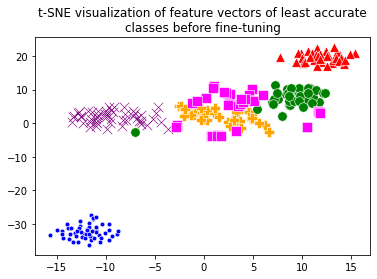

In [43]:
message = "t-SNE visualization of feature vectors of least accurate classes before fine-tuning"
tsne_visualize(message, least_accurate_classes_before_finetuning, feature_list)

### Classes with Worst Accuracy after Fine-tuning

In [31]:
least_accurate_classes_after_finetuning, accuracy_per_class_after_finetuning = get_least_accurate_classes(
    finetuned_feature_list[:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Accuracy is  95.52


Top 10 incorrect classifications

water_lilly 	Accuracy:  66.23
schooner 	Accuracy:  68.77
crayfish 	Accuracy:  74.38
lobster 	Accuracy:  74.52
octopus 	Accuracy:  77.97
crocodile 	Accuracy:  78.18
mandolin 	Accuracy:  80.49
beaver 	Accuracy:  80.77
brontosaurus 	Accuracy:  80.95
lotus 	Accuracy:  81.64


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 265 samples in 0.002s...
[t-SNE] Computed neighbors for 265 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 265 / 265
[t-SNE] Mean sigma: 0.289319
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.485455
[t-SNE] KL divergence after 1000 iterations: 0.134770
t-SNE done! Time elapsed: 1.478806495666504 seconds


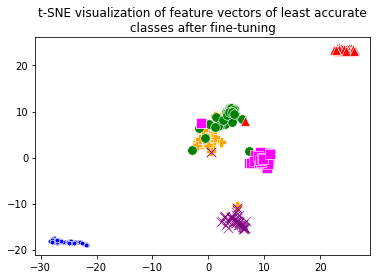

In [44]:
message = "t-SNE visualization of feature vectors of least accurate classes after fine-tuning"
tsne_visualize(message, least_accurate_classes_after_finetuning, finetuned_feature_list)


Comparing the scattered t-SNE embeddings of pre-trained model against those of the fine-tuned model, it is observable that a Machine Learning classifier will be able to find a plane of seperation between these classes with much more ease with fine-tuned model, hence giving better classification accuracy. Moreover, for finding similar images, the fine-tune model will give improved similarity results.
